In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

### I. Loading data and processing data

In [2]:
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds_by_hour.csv')

In [3]:
df['sonyc_sensor_id'].isnull().sum()

42824

In [4]:
df.shape

(84894, 28)

In [5]:
# split into year, month, day, hour in UTC and in Local Time Zone (EST)
df['timestamp_utc'] = pd.to_datetime(df.timestamp_utc)
df['year'] = pd.DatetimeIndex(df.timestamp_utc).year
df['month'] = pd.DatetimeIndex(df.timestamp_utc).month
df['day'] = pd.DatetimeIndex(df.timestamp_utc).day
df['hour'] = pd.DatetimeIndex(df.timestamp_utc).hour

df['localtime'] = pd.to_datetime(df.timestamp_utc).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['localyear'] = pd.DatetimeIndex(df.localtime).year
df['localmonth'] = pd.DatetimeIndex(df.localtime).month
df['localday'] = pd.DatetimeIndex(df.localtime).day
df['localhour'] = pd.DatetimeIndex(df.localtime).hour

#get week of year 
df['weeknumber'] = df['timestamp_utc'].dt.week
#get day of year
df['dayofyear'] = df['timestamp_utc'].dt.dayofyear

In [6]:
df.sonyc_sensor_name.unique()

array(['19 Washington Square North', nan, 'Silver lab', 'Juan Carlos',
       'Shimkin Reading Room', '4 Washington Square North',
       'Kimmel Center'], dtype=object)

<b>Create a new dataframe df_new with localhour in range [4am, 8am] mainly for four sensors</b>
<li>'Silver Lab' sensor: doesn't have YAMNet predication data
<li>'Shimkin Reading Room' sensor: records little bird calls according to YAMNet data

In [7]:
df_new = df[(df.localhour>=4) & (df.localhour <=8) &\
            (df['sonyc_sensor_name'] != 'Shimkin Reading Room') &\
            (df['sonyc_sensor_name'] != 'Silver lab') &\
            (df['sonyc_sensor_name'].isnull() == False) \
            ].copy()
            #(df['pct_positive_predictions'].isnull() == False)

df_new.rename(columns={'avg_mt_#/km':'avg_mt_km','avg_mtr_#/km/h':'avg_mtr_kmh'}, inplace = True)

In [8]:
df_new.shape    

(6357, 39)

In [9]:
df_new.sonyc_sensor_name.unique()

array(['19 Washington Square North', 'Juan Carlos',
       '4 Washington Square North', 'Kimmel Center'], dtype=object)

In [10]:
df_new.localhour.unique()

array([4, 5, 6, 7, 8])

In [11]:
df_new.columns

Index(['timestamp_utc', 'sonyc_sensor_id', 'sonyc_sensor_name',
       'dBAS_lin_mean', 'l1', 'l10', 'l5', 'l90',
       'count_of_positive_predictions', 'pct_positive_predictions',
       'avg_mtr_kmh', 'avg_mt_km', 'avg_height_m', 'temp_celcius',
       'dewp_celcius', 'rh_percentage', 'wind_dir', 'wind_speed_mph',
       'sea_level_pressure_mb', 'precipitation_mm', 'visibility_miles',
       'gust_mph', 'peak_wind_gust_mph', 's_19WashingtonSquareNorth',
       's_juanCarlos', 's_shimkinReadingRoom', 's_4WashingtonSquareNorth',
       's_kimmelCenter', 'year', 'month', 'day', 'hour', 'localtime',
       'localyear', 'localmonth', 'localday', 'localhour', 'weeknumber',
       'dayofyear'],
      dtype='object')

In [12]:
df_new['pct_positive_predictions'].isnull().sum()  

2700

### II. Time series analysis

<b>Selected features:</b>
pct_positive_predictions (YAMNet), dBAS_lin_mean (SPL), avg_mt_km (Nexrad), temp_celcius (Weather)

<b>Time Range:</b>
Late February to early May for 2017, 2018, 2019, 2020

<b>Sensors:</b>
'19 Washington Square North', 'Juan Carlos', '4 Washington Square North', 'Kimmel Center'

In [13]:
import statsmodels.formula.api as smf
import statsmodels.api as sm   
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy

#### i. Preprocessing 

In [14]:
features = ['yamnet','spl','nexrad','weather']
features_dict = {'yamnet':'pct_positive_predictions','spl':'dBAS_lin_mean','nexrad':'avg_mt_km','weather':'temp_celcius'}
years = ['2017','2018','2019','2020']

In [15]:
#dynamically create a dataframe for each feature for each year (16 dataframes in total)
for feature in features:
    feature_col = features_dict[feature]
    for year in years:
        #group by month, day, and hour
        locals()['df_{0}_{1}'.format(feature, year)] = df_new[(df_new.localyear == int(year))]\
                                    .groupby(['localmonth','localday','localhour']).mean()\
                                    .loc[:, [feature_col]].reset_index()
        
        #format time index to string 'YYYY-MM-DD-HH'
        date = [0]*len(locals()['df_{0}_{1}'.format(feature, year)]['localmonth'])
        for index, row in locals()['df_{0}_{1}'.format(feature, year)].iterrows():
            date[index] = '-'.join([year,str(int(row[0])),str(int(row[1])),str(int(row[2]))])
            
        locals()['df_{0}_{1}'.format(feature, year)]['date'] = date
        
        #convert string time to datetime
        locals()['df_{0}_{1}'.format(feature, year)]['date'] = pd.to_datetime(\
                    locals()['df_{0}_{1}'.format(feature, year)]['date'], format='%Y-%m-%d-%I')
        
        #loc feature and date columns, set date column as index
        locals()['df_{0}_{1}'.format(feature, year)] = locals()['df_{0}_{1}'.format(feature, year)]\
                                    .loc[:,['date',feature_col]]
        locals()['df_{0}_{1}'.format(feature, year)].set_index('date',inplace=True)
        locals()['df_{0}_{1}'.format(feature, year)].dropna(inplace = True)
        

In [16]:
df_yamnet_2017.head()

,pct_positive_predictions
date,
2017-03-01 04:00:00,0.033337
2017-03-01 05:00:00,0.000000
2017-03-01 06:00:00,0.000000
2017-03-01 07:00:00,0.008335
2017-03-01 08:00:00,0.058335


#### ii. Apply seasonal decomposition from statsmodel  

In [17]:
#Set figure size
plt.rcParams['figure.figsize'] = [8, 8]

#### (a) Daily Period

Feature: pct_positive_predictions Year: 2017


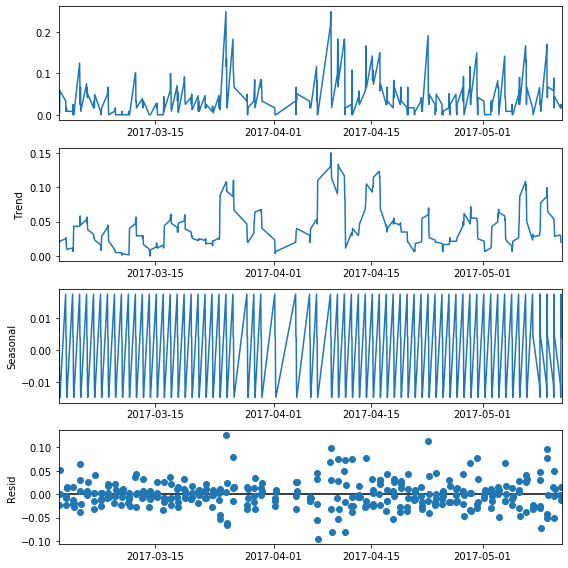

Feature: pct_positive_predictions Year: 2018


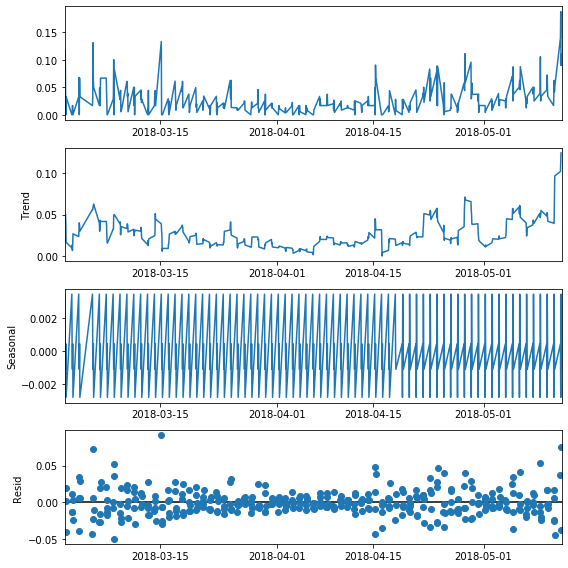

Feature: pct_positive_predictions Year: 2019


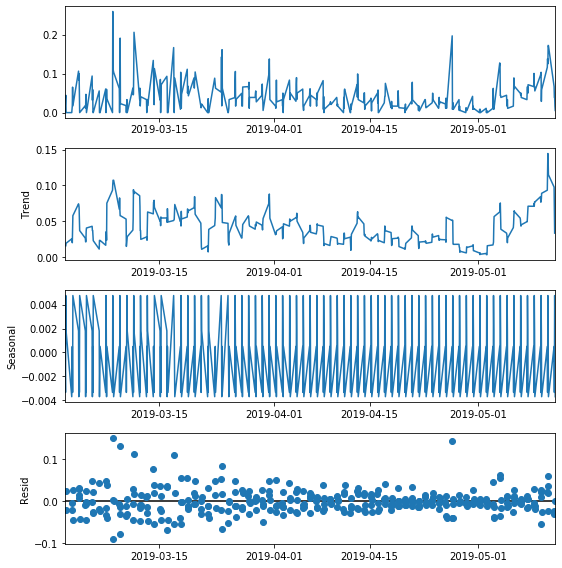

Feature: pct_positive_predictions Year: 2020


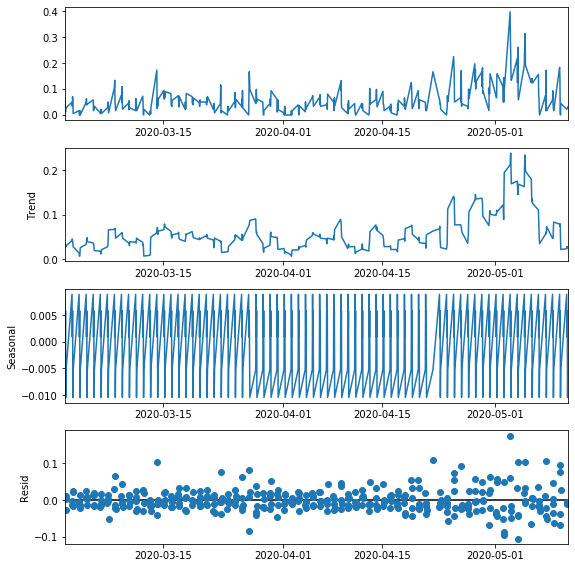

Feature: dBAS_lin_mean Year: 2017


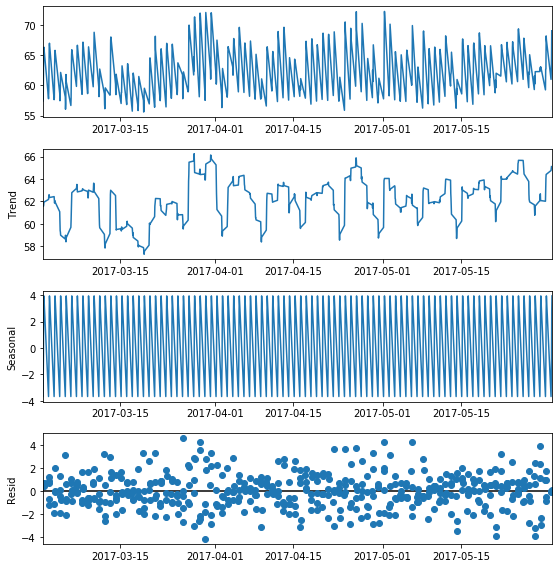

Feature: dBAS_lin_mean Year: 2018


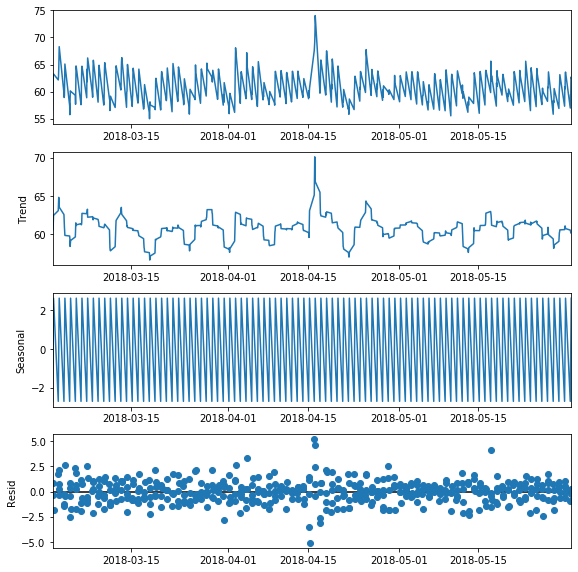

Feature: dBAS_lin_mean Year: 2019


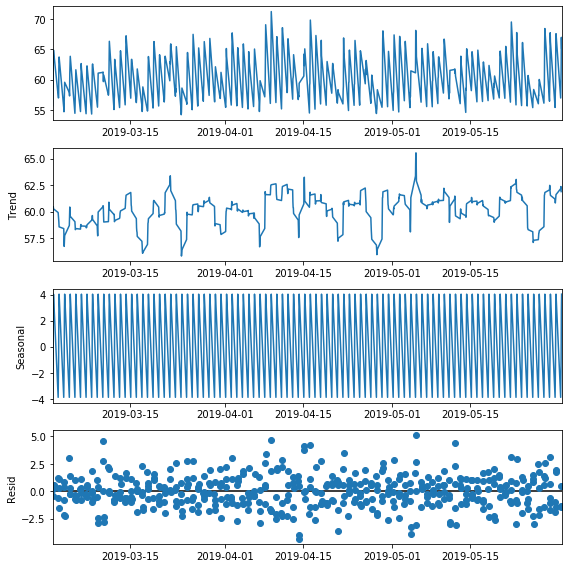

Feature: dBAS_lin_mean Year: 2020


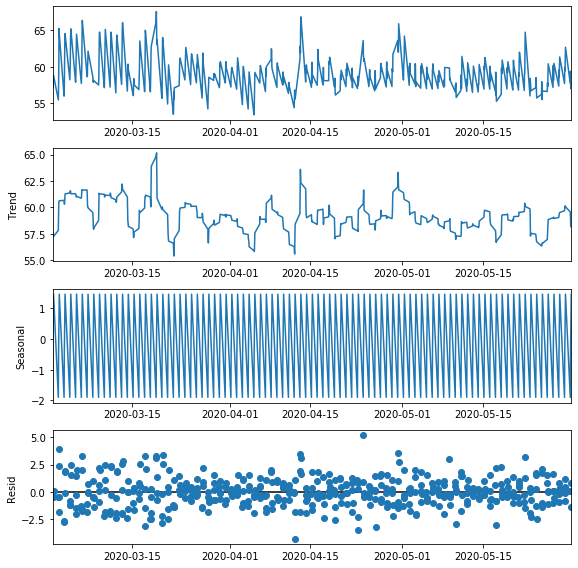

Feature: avg_mt_km Year: 2017


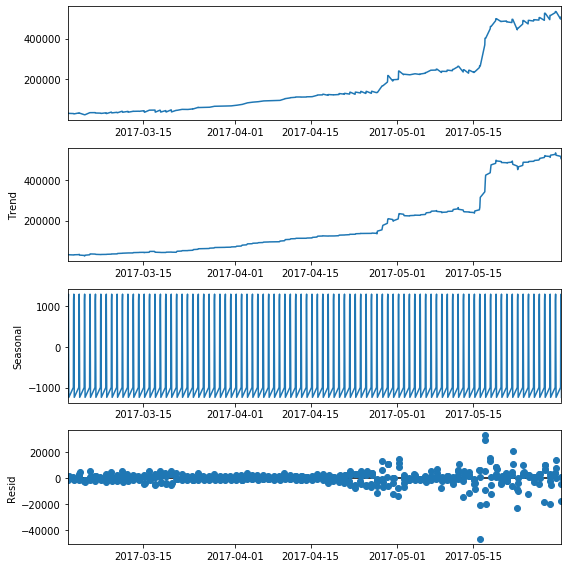

Feature: avg_mt_km Year: 2018


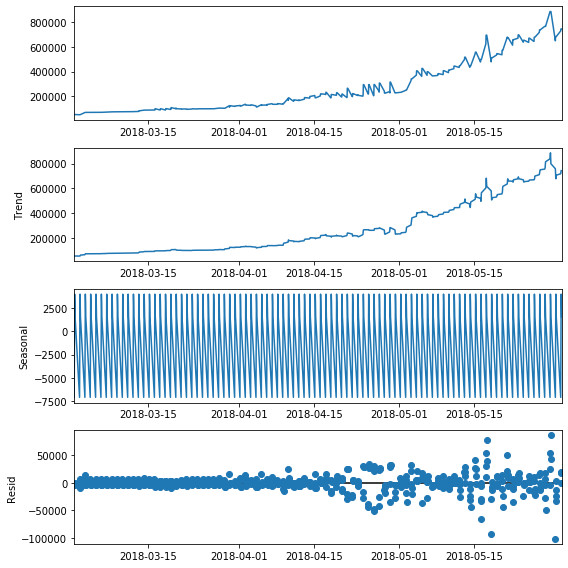

Feature: avg_mt_km Year: 2019


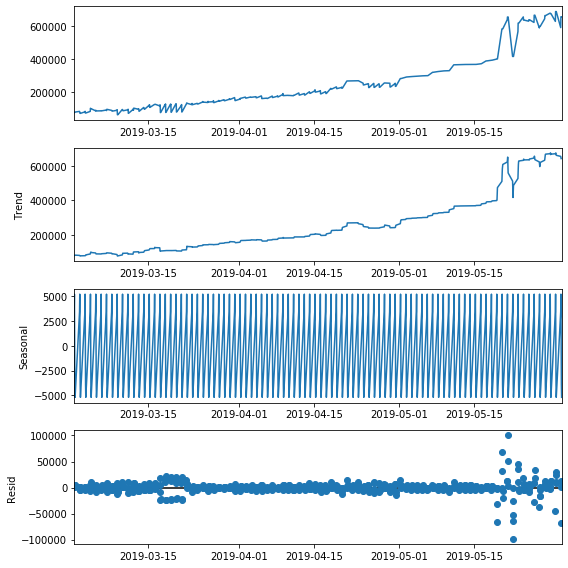

Feature: avg_mt_km Year: 2020


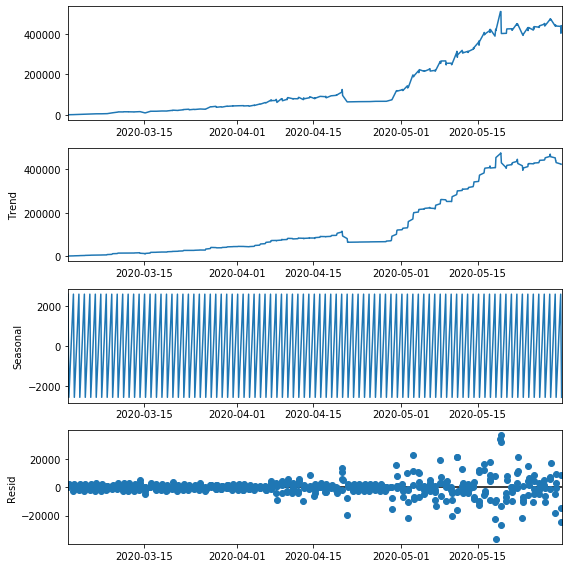

Feature: temp_celcius Year: 2017


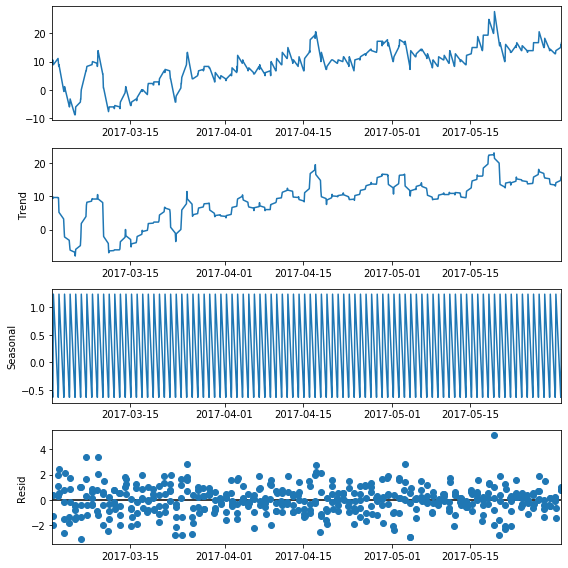

Feature: temp_celcius Year: 2018


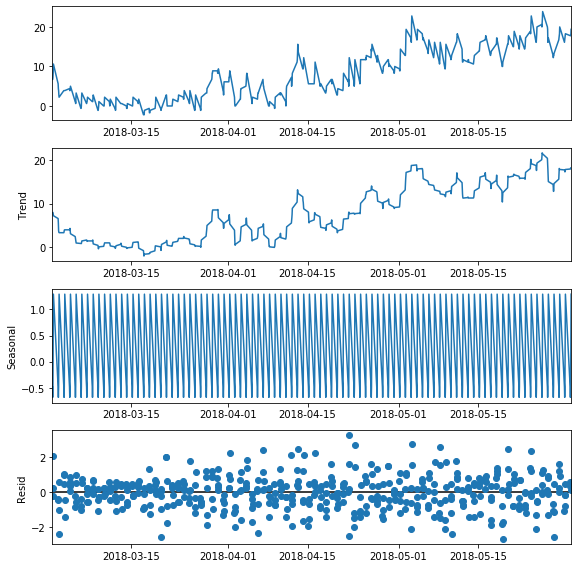

Feature: temp_celcius Year: 2019


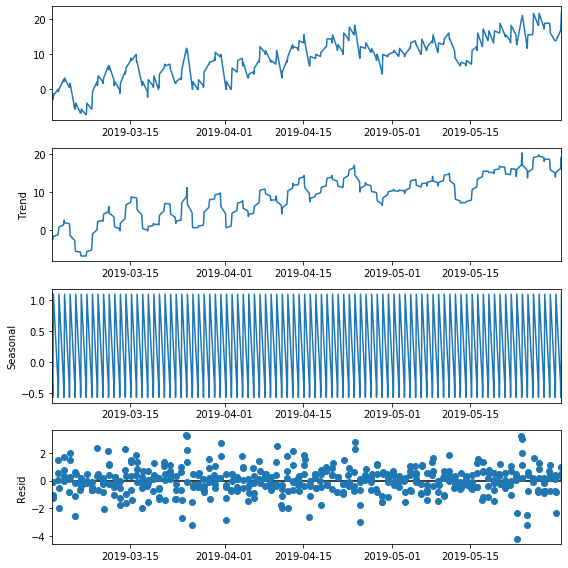

Feature: temp_celcius Year: 2020


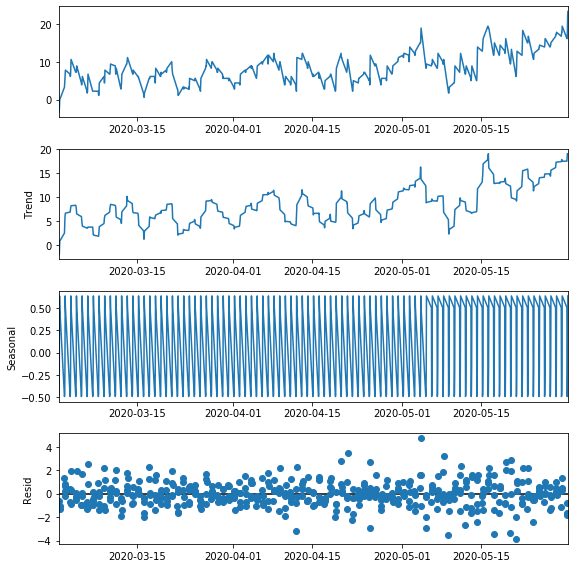

In [18]:
for feature in features:
    feature_col = features_dict[feature]
    for year in years:
        #Additive Model
        res = sm.tsa.seasonal_decompose(locals()['df_{0}_{1}'.format(feature, year)],model='additive',period=5)  #5 hours: 4，5，6，7，8
        print('Feature: ' + feature_col + ' Year: ' + year)
        res.plot()
        plt.show()

The daily period decomposition changes frequently.

#### (b) Weekly Period

Feature: pct_positive_predictions Year: 2017


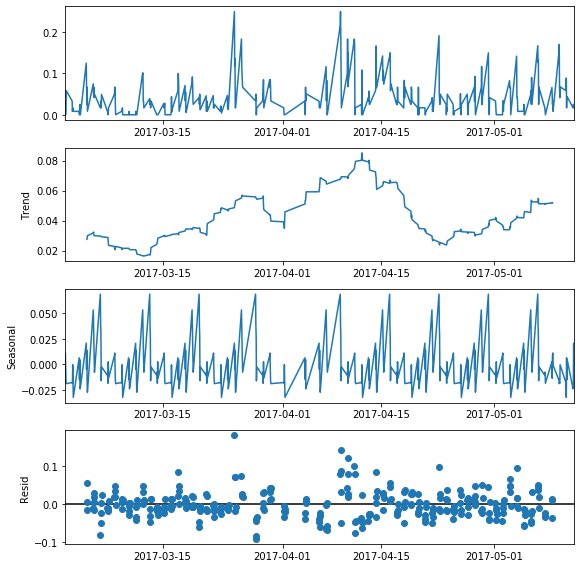

Feature: pct_positive_predictions Year: 2018


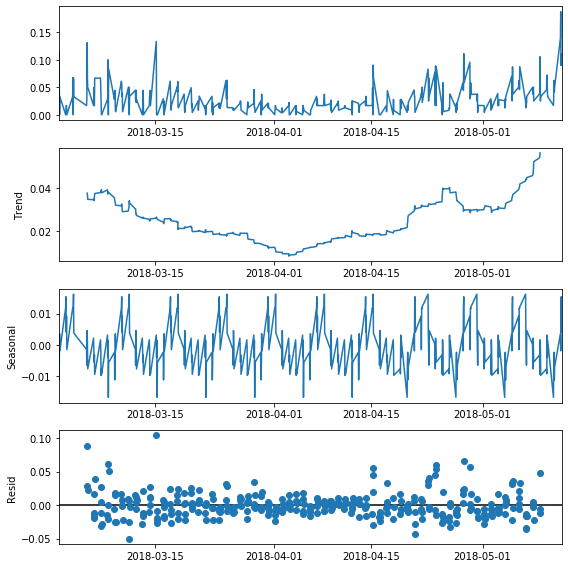

Feature: pct_positive_predictions Year: 2019


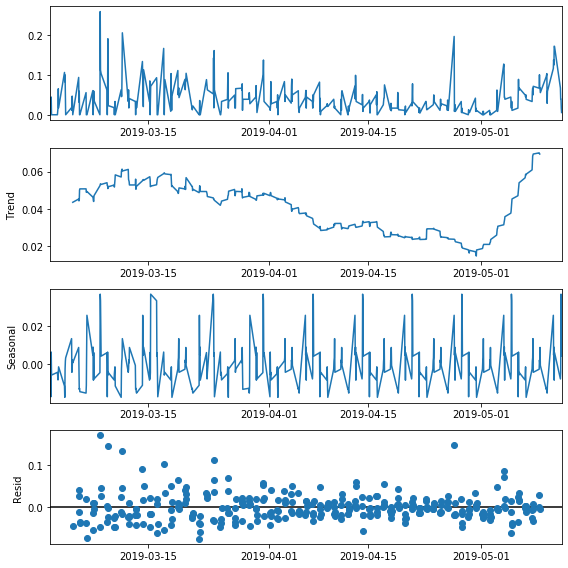

Feature: pct_positive_predictions Year: 2020


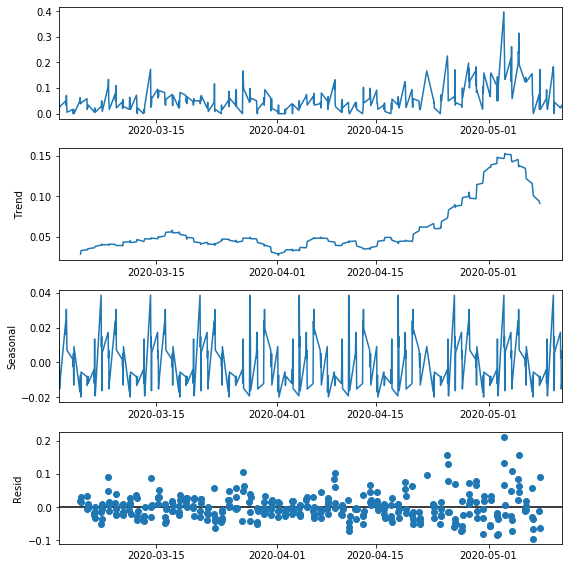

Feature: dBAS_lin_mean Year: 2017


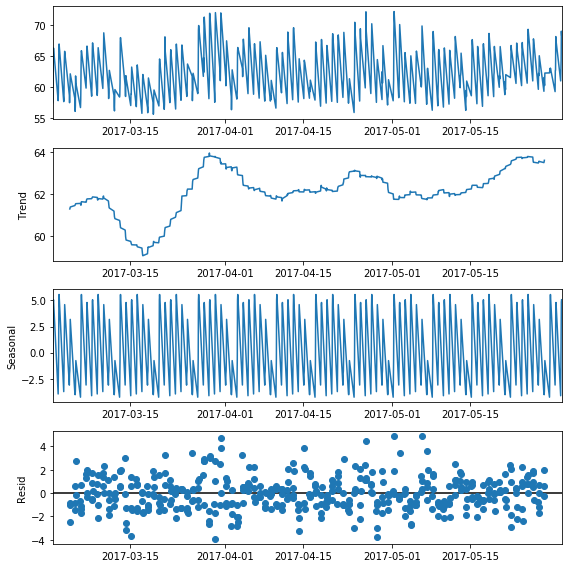

Feature: dBAS_lin_mean Year: 2018


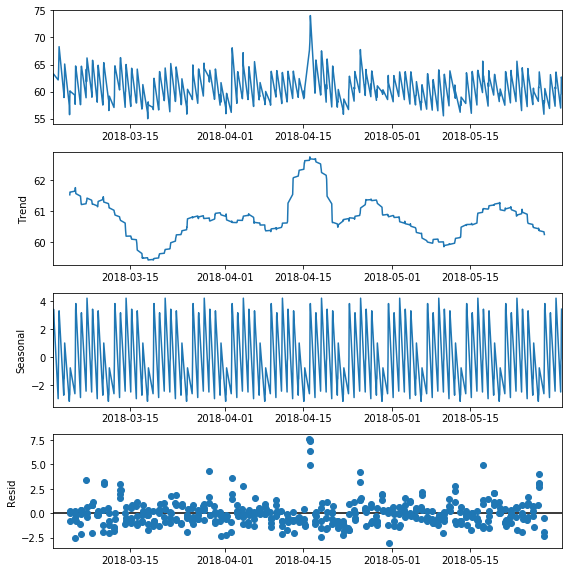

Feature: dBAS_lin_mean Year: 2019


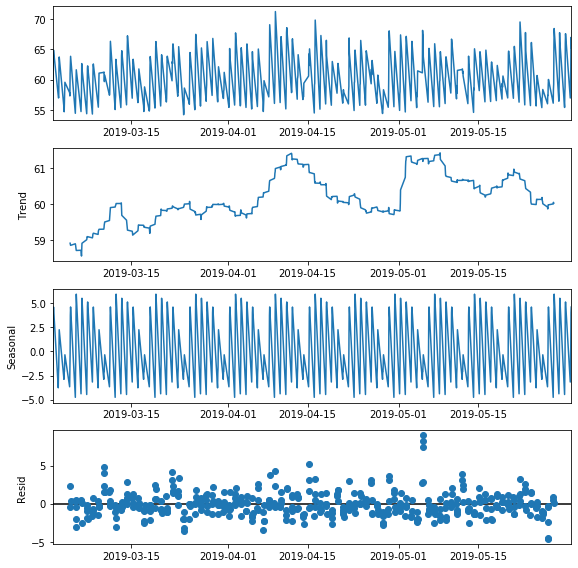

Feature: dBAS_lin_mean Year: 2020


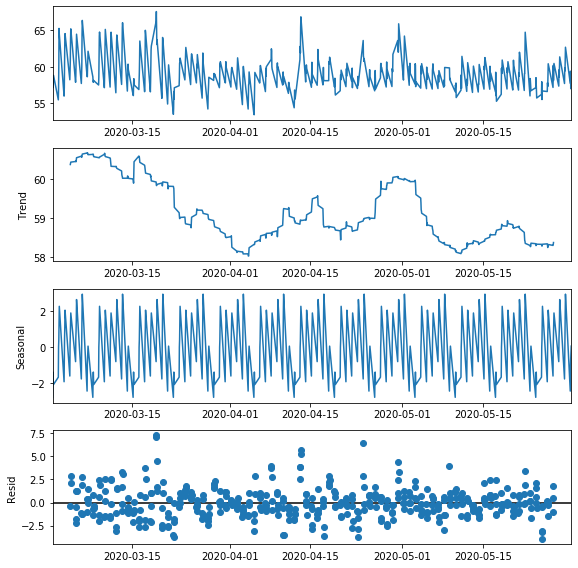

Feature: avg_mt_km Year: 2017


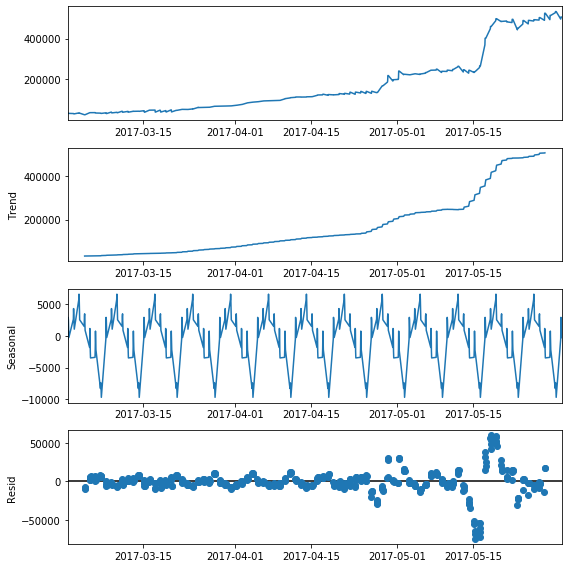

Feature: avg_mt_km Year: 2018


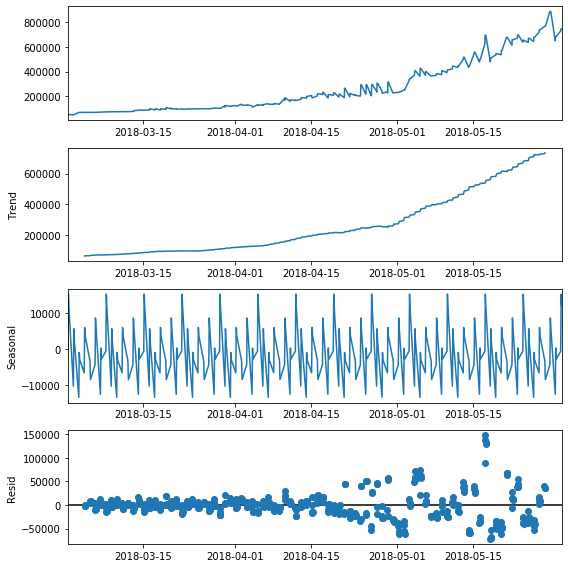

Feature: avg_mt_km Year: 2019


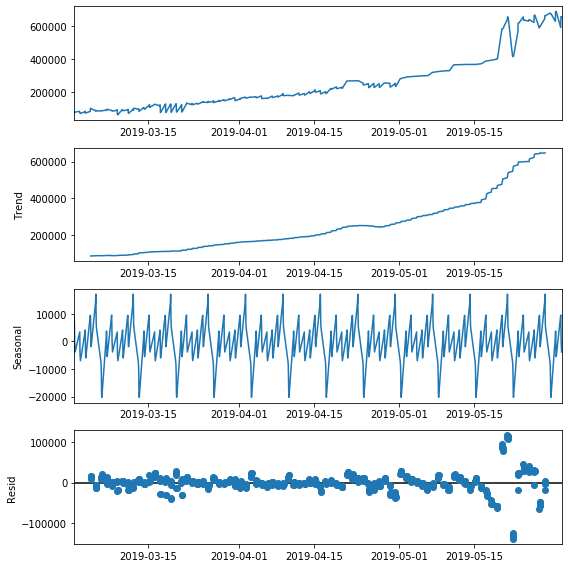

Feature: avg_mt_km Year: 2020


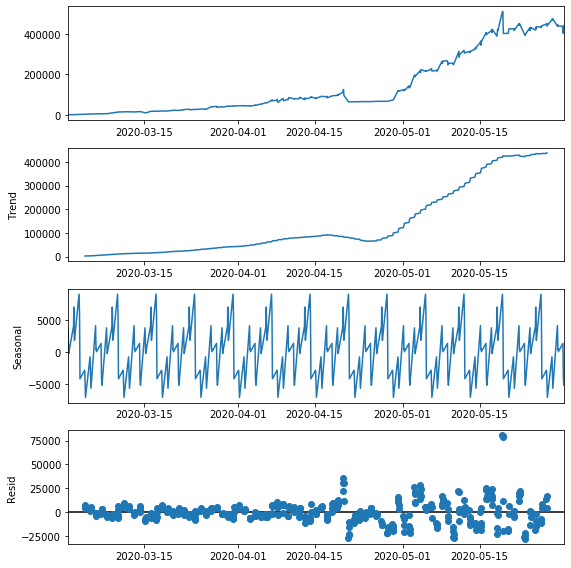

Feature: temp_celcius Year: 2017


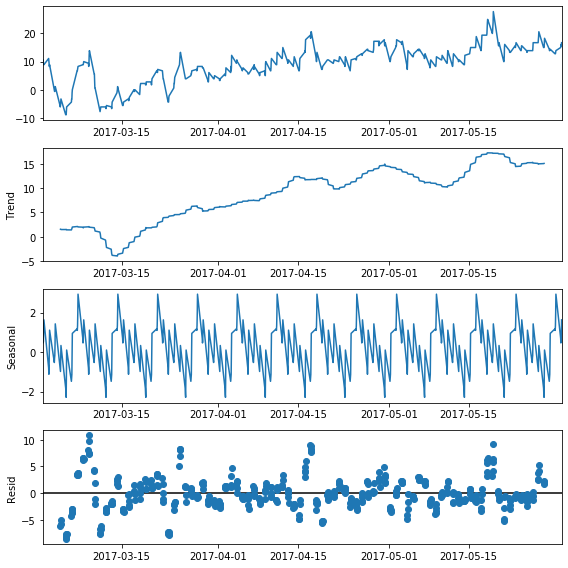

Feature: temp_celcius Year: 2018


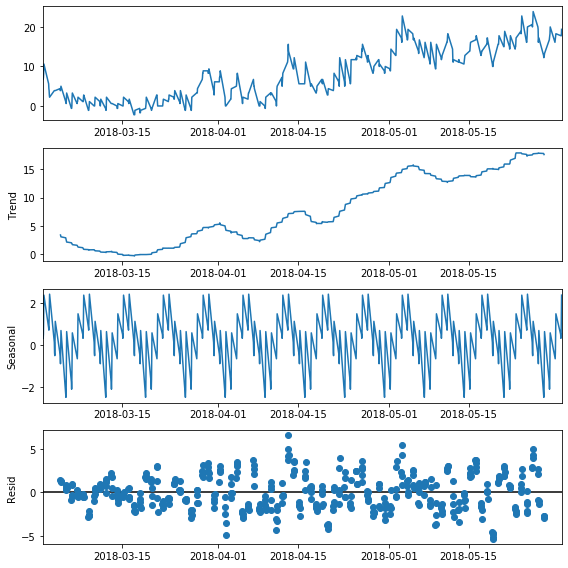

Feature: temp_celcius Year: 2019


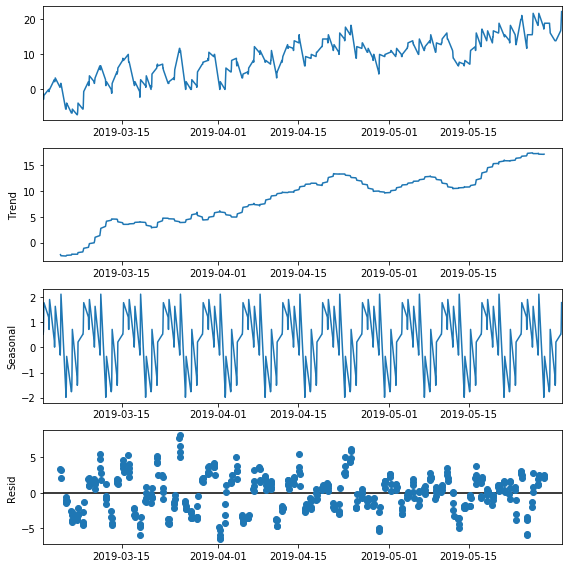

Feature: temp_celcius Year: 2020


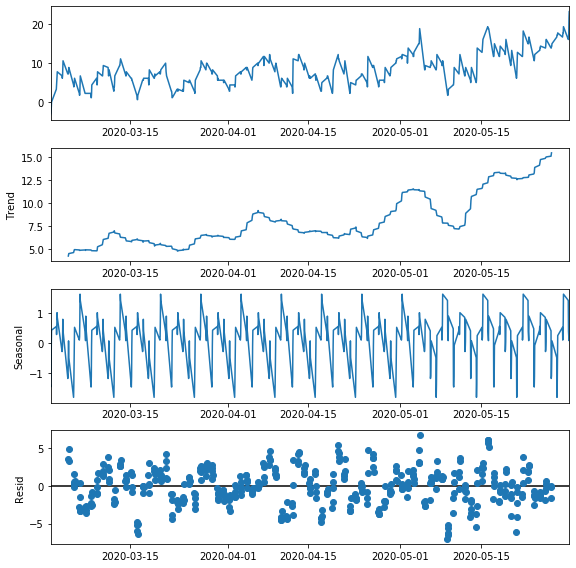

In [19]:
for feature in features:
    feature_col = features_dict[feature]
    for year in years:
        #Additive Model
        res = sm.tsa.seasonal_decompose(locals()['df_{0}_{1}'.format(feature, year)],model='additive',period=35)  #5 hours * 7 days
        print('Feature: ' + feature_col + ' Year: ' + year)
        res.plot()
        plt.show()
        
        #add trend and resid to each dataframe
        locals()['df_{0}_{1}'.format(feature, year)]['trend_{}'.format(feature_col)] = res.trend
        locals()['df_{0}_{1}'.format(feature, year)]['resid_{}'.format(feature_col)] = res.resid
        

In [20]:
df_yamnet_2017.iloc[25:30,:]

,pct_positive_predictions,trend_pct_positive_predictions,resid_pct_positive_predictions
date,,,
2017-03-06 04:00:00,0.01667,0.029729,-0.081797
2017-03-06 05:00:00,0.01695,0.029736,-0.051230
2017-03-06 06:00:00,0.03333,0.029502,-0.024896
2017-03-06 07:00:00,0.01667,0.029268,0.003612
2017-03-06 08:00:00,0.04918,0.029268,0.022461


#### Concatenate residuals from each dataframe into one dataframe df_resid

In [21]:
for year in years:
    #make column resid_pct_positive_predictions a dataframe
    locals()['df_resid_{}'.format(year)] = locals()['df_yamnet_{}'.format(year)]['resid_pct_positive_predictions'].to_frame() 
    
    #merge the residuals from the other three features' df to one dataframe
    for feature in features[1:]:
        feature_col = features_dict[feature]
        df_temp = locals()['df_{0}_{1}'.format(feature, year)]['resid_{}'.format(feature_col)].to_frame()
        locals()['df_resid_{}'.format(year)] = locals()['df_resid_{}'.format(year)].merge(df_temp,\
                        how = 'outer', left_index = True, right_index = True)

In [22]:
#get the shape of residual dataframe for four years
df_resid_2017.shape,df_resid_2018.shape,df_resid_2019.shape,df_resid_2020.shape

((460, 4), (460, 4), (460, 4), (455, 4))

In [23]:
df_resid_2017.iloc[20:25,:]

,resid_pct_positive_predictions,resid_dBAS_lin_mean,resid_avg_mt_km,resid_temp_celcius
date,,,,
2017-03-05 04:00:00,-0.010148,0.582824,5203.602078,-8.537750
2017-03-05 05:00:00,-0.017019,-1.420716,2229.989392,-8.238035
2017-03-05 06:00:00,0.019455,-0.886240,2450.632974,-8.120233
2017-03-05 07:00:00,0.006549,2.766489,5645.596728,-7.711242
2017-03-05 08:00:00,0.027828,-0.155581,6552.627489,-7.636171


In [24]:
#concatenate four dataframes into one
df_resid = pd.concat([df_resid_2017,df_resid_2018,df_resid_2019,df_resid_2020])

In [25]:
df_resid.shape

(1835, 4)

#### Concatenate trends from each dataframe into one dataframe df_trend

In [26]:
for year in years:
    #make column trend_pct_positive_predictions a dataframe
    locals()['df_trend_{}'.format(year)] = locals()['df_yamnet_{}'.format(year)]['trend_pct_positive_predictions'].to_frame() 
    
    #merge the trends from the other three features' df to one dataframe
    for feature in features[1:]:
        feature_col = features_dict[feature]
        df_temp = locals()['df_{0}_{1}'.format(feature, year)]['trend_{}'.format(feature_col)].to_frame()
        locals()['df_trend_{}'.format(year)] = locals()['df_trend_{}'.format(year)].merge(df_temp,\
                        how = 'outer', left_index = True, right_index = True)

In [27]:
#get the shape of trends dataframe for four years
df_trend_2017.shape,df_trend_2018.shape,df_trend_2019.shape,df_trend_2020.shape

((460, 4), (460, 4), (460, 4), (455, 4))

In [28]:
#concatenate four dataframes into one
df_trend = pd.concat([df_trend_2017,df_trend_2018,df_trend_2019,df_trend_2020])

In [29]:
df_trend.shape

(1835, 4)

#### Write residuals and trends to csv (freq = week)

In [30]:
!pwd

/gws_gpfs/projects/project-urban_birds/workspace/xy1443/urban_birds/model


In [31]:
df_resid.to_csv('../../../share/data/statsmodel_weekly_residuals.csv')

In [32]:
df_trend.to_csv('../../../share/data/statsmodel_weekly_trends.csv')

#### (c) Regression analysis on residuals and trends

<li><b> Analysis on residuals

In [33]:
df_resid.shape

(1835, 4)

In [34]:
factors = ['resid_dBAS_lin_mean', 'resid_avg_mt_km','resid_temp_celcius']

formula = 'resid_pct_positive_predictions~'+ '+'.join(factors) 
formula

'resid_pct_positive_predictions~resid_dBAS_lin_mean+resid_avg_mt_km+resid_temp_celcius'

#### Formula: YAMNet_resid ~ SPL_resid + Nexrad_resid + Temperature_resid 

In [35]:
#(WITHOUT INTERCEPT)
lm = smf.ols(formula=formula, data = df_resid).fit()
print(lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     resid_pct_positive_predictions   R-squared:                       0.003
Model:                                        OLS   Adj. R-squared:                  0.000
Method:                             Least Squares   F-statistic:                     1.154
Date:                            Mon, 20 Jul 2020   Prob (F-statistic):              0.326
Time:                                    20:27:44   Log-Likelihood:                 2506.5
No. Observations:                            1259   AIC:                            -5005.
Df Residuals:                                1255   BIC:                            -4984.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--

<li><b> Analysis on trends

In [36]:
df_trend.shape

(1835, 4)

In [37]:
#Drop NAN valuess
df_trend.dropna(inplace = True)
df_trend.shape

(1259, 4)

#### Formula: YAMNet_trend ~ SPL_trend+ Nexrad_trend + Temperature_trend -1 (WITHOUT INTERCEPT)

In [38]:
factors = ['trend_dBAS_lin_mean', 'trend_avg_mt_km','trend_temp_celcius']

formula = 'trend_pct_positive_predictions~'+ '+'.join(factors) + '-1'
formula

'trend_pct_positive_predictions~trend_dBAS_lin_mean+trend_avg_mt_km+trend_temp_celcius-1'

In [39]:
lm2_1 = smf.ols(formula=formula, data = df_trend).fit()
print(lm2_1.summary())

                                       OLS Regression Results                                      
Dep. Variable:     trend_pct_positive_predictions   R-squared (uncentered):                   0.784
Model:                                        OLS   Adj. R-squared (uncentered):              0.784
Method:                             Least Squares   F-statistic:                              1524.
Date:                            Mon, 20 Jul 2020   Prob (F-statistic):                        0.00
Time:                                    20:27:44   Log-Likelihood:                          3010.2
No. Observations:                            1259   AIC:                                     -6014.
Df Residuals:                                1256   BIC:                                     -5999.
Df Model:                                       3                                                  
Covariance Type:                        nonrobust                                                  


In [40]:
#predicted regression values
df_trend['ypred_lm2_1']=lm2_1.predict() 

In [41]:
df_trend_2017 = df_trend.iloc[:299,:]

In [42]:
plt.rcParams['figure.figsize'] = [8, 4]

Text(0, 0.5, 'pct_positive_predictions')

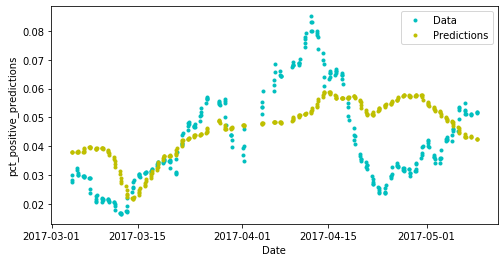

In [43]:
plt.plot(df_trend_2017.index,df_trend_2017.trend_pct_positive_predictions,'.c', label='Data') #plot the data
plt.plot(df_trend_2017.index,df_trend_2017.ypred_lm2_1,'.y', label='Predictions') #plot the regression
plt.legend()
plt.xlabel('Date')
plt.ylabel('pct_positive_predictions')

#### Formula: YAMNet_trend ~ SPL_trend+ Nexrad_trend + Temperature_trend (WITH INTERCEPT)

In [44]:
formula = 'trend_pct_positive_predictions~'+ '+'.join(factors)
formula

'trend_pct_positive_predictions~trend_dBAS_lin_mean+trend_avg_mt_km+trend_temp_celcius'

In [45]:
#(WITH INTERCEPT)
lm2 = smf.ols(formula=formula, data = df_trend).fit()
print(lm2.summary())

                                  OLS Regression Results                                  
Dep. Variable:     trend_pct_positive_predictions   R-squared:                       0.188
Model:                                        OLS   Adj. R-squared:                  0.186
Method:                             Least Squares   F-statistic:                     96.93
Date:                            Mon, 20 Jul 2020   Prob (F-statistic):           1.99e-56
Time:                                    20:27:44   Log-Likelihood:                 3064.3
No. Observations:                            1259   AIC:                            -6121.
Df Residuals:                                1255   BIC:                            -6100.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--

In [46]:
#predicted regression values
df_trend['ypred_lm2']=lm2.predict()     

In [47]:
df_trend_2017 = df_trend.iloc[:299,:]

Text(0, 0.5, 'pct_positive_predictions')

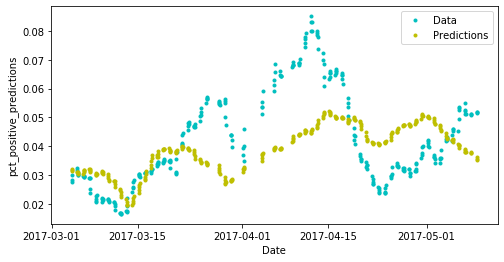

In [48]:
plt.plot(df_trend_2017.index,df_trend_2017.trend_pct_positive_predictions,'.c', label='Data') #plot the data
plt.plot(df_trend_2017.index,df_trend_2017.ypred_lm2,'.y', label='Predictions') #plot the regression
plt.legend()
plt.xlabel('Date')
plt.ylabel('pct_positive_predictions')